# 1 Introduction

Ziel des Kapitels:
- Welche Vorraussetzungen werden erwartet?
- Verweise zu anderen Literaturstellen, die notwendige Grundlagen behandeln.
- Was wird gelehrt?
- Schaffung einer Basis, auf der der Kurs im Alleinstudium durchgezogen werden kann.

In Kürze beschreiben:
- Aufbau und Zielen des Kurses
- Scope der genutzten Software (CoolProp, TESPy, ...)
- Stoffwertedaten, Komponentenbasierte Simulation, Numerik
- Kurzeinführung in Begriffe und grundlegende Gleichungen

## Goals and Scope of the Course

## Fluid Properties and Mathematical Description

## Fundamentals of Exergy Analysis

### Physical Exergy


### Chemical Exergy


# 2 Single Components

Ziele des Kapitels
- Anwendung der Grundlagen auf sehr einfache Anwendungen
- Exergy anhand einzelner Komponenten "spürbar" machen.
- Unterschiede zwischen Energieanalyse und Exergieanalyse aufzeigen
- Auf Nutzung von komponentenbasierter thermodynamischer Simulationssoftware hinarbeiten (hier wird auch auf Literatur und speziell die online Dokumentation von TESPy verwiesen, aber dennoch sollte der Vorteil eines Frameworks gegenüber manuell programmieren deutlich werden)


## Compressor/Valve

## Heat Exchanger

## Compressed Air Production

We want to consider compression of air and cooling it the fluid to the ambient
temperature.

\begin{equation}
    T_3 = T_1
    p_3 > p_1\\
\end{equation}

Applying energy analysis to the overall system neglecting the influence of
potential and kinetic energy to the thermal system, we can calculate the total
amount of energy transferred over the system boundaries $\dot E$:

\begin{equation}
    \dot E =\dot m \cdot \left( h_3 - h_1\right)
\end{equation}

However, we can see that the change in enthalpy is nearly zero, since $h_1$ and
$h_3$ are almost equal.

\begin{equation}
    h_\left(p_1, T_1\right) \sim h_\left(p_3, T_3\right)
\end{equation}

We can easily verify this claim:

In [1]:
from CoolProp.CoolProp import PropsSI

T_amb = 30  # °C
p_amb = 1.01325  # bar
fluid = "air"

p_3 = 5  # bar

p_amb_SI = p_amb * 1e5  # Pa
p_3_SI = p_3 * 1e5  # Pa
T_amb_SI = T_amb + 273.15  # K

h_1 = PropsSI("H", "P", p_amb_SI, "T", T_amb_SI, fluid)
h_3 = PropsSI("H", "P", p_3_SI, "T", T_amb_SI, fluid)

print(f"Change in enthalpy: {round(h_3 - h_1)} J/kg")

Change in enthalpy: -880 J/kg


It even looks as if energy has been produced by our setup, since the change in enthalpy is
negative. We can see, how the enthalpy of air changes with pressure given 
isothermal process:

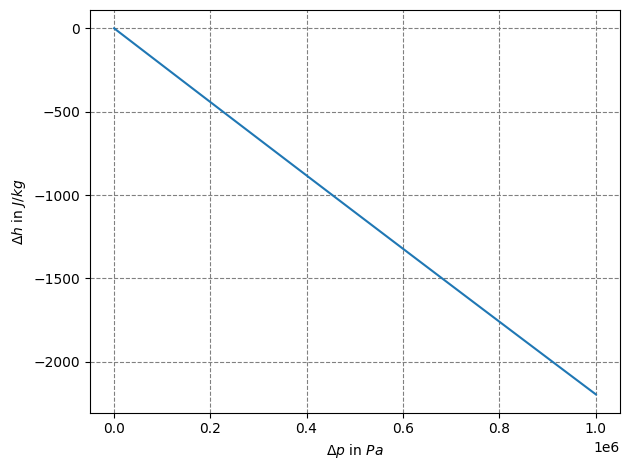

In [2]:
import numpy as np
from matplotlib import pyplot as plt

p_ref = 1e3  # Pa
p_max = 1e6  # Pa
p_range = np.linspace(p_ref, p_max)  # Pa
T_ref = 303.15  # K

h_ref = PropsSI("H", "P", p_ref, "T", T_ref, fluid)
h = PropsSI("H", "P", p_range, "T", T_ref, fluid)

fig, ax = plt.subplots(1)

ax.plot(p_range, h - h_ref)
ax.set_xlabel("$\Delta p$ in $Pa$")
ax.set_ylabel("$\Delta h$ in $J/kg$")

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.tight_layout()

For ideal gases, the change in enthalpy will be exactly zero, as the enthalpy
does not depend on change in pressure but only on change in temperature:

\begin{equation}
    h\left(T\right) - h\left(T_\text{ref}\right) = c_\text{p}\left(T\right) \cdot \left(T - T_\text{ref}\right)
\end{equation}

To visualize the energy stored in the pressurized air, we can apply the exergy
method and split the exergy in its thermal and mechanical shares.

\begin{equation}
    h_\left(p_1, T_1\right) \sim h_\left(p_3, T_3\right)
\end{equation}

Mechanical exergy at reference state: 0 J/kg


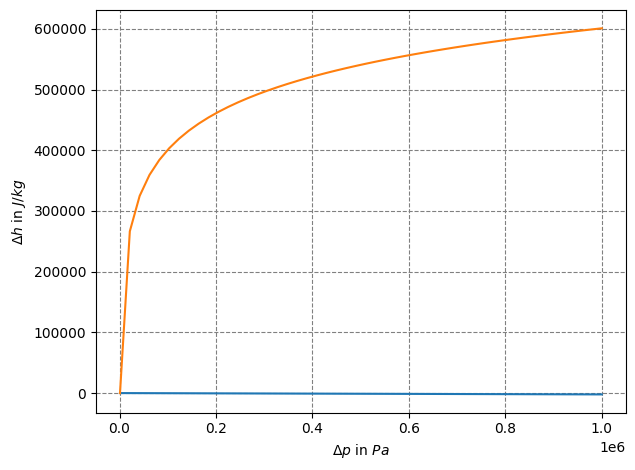

In [3]:
from tespy.connections import Connection
from tespy.components import Sink, Source
from tespy.networks import Network


Network(["air"])


ref = Connection(Source("Dummysource1"), "out1", Sink("Dummysink1"), "in1")
c = Connection(Source("Dummysource2"), "out1", Sink("Dummysink2"), "in1")

ref.fluid.val = {"air": 1}
ref.p.val_SI = p_ref
ref.T.val_SI = T_ref
ref.h.val_SI = PropsSI("H", "P", p_ref, "T", T_ref, "air")
ref.s.val_SI = PropsSI("S", "P", p_ref, "T", T_ref, "air")

ref.get_physical_exergy(p_ref, T_ref)
print(f"Mechanical exergy at reference state: {round(ref.ex_mech)} J/kg")
# print(f"Thermal exergy at reference state: {round(ref.ex_therm)} J/kg")

c.fluid.val = {"air": 1}
c.T.val_SI = T_ref

ex = []

for p in p_range:
    c.p.val_SI = p
    c.h.val_SI = PropsSI("H", "P", p, "T", T_ref, "air")
    c.s.val_SI = PropsSI("S", "P", p, "T", T_ref, "air")

    c.get_physical_exergy(p_ref, T_ref)
    ex += [c.ex_mech]
    

ax.plot(p_range, ex)    
display(fig)
plt.close(fig)

With a closer look at the compressor assuming isentropic compression, we see that
the physical exergy $ex^\text{PH}$ of the compressed air is identical to the 
isentropic compression energy $w = h_\text{is} - h$:

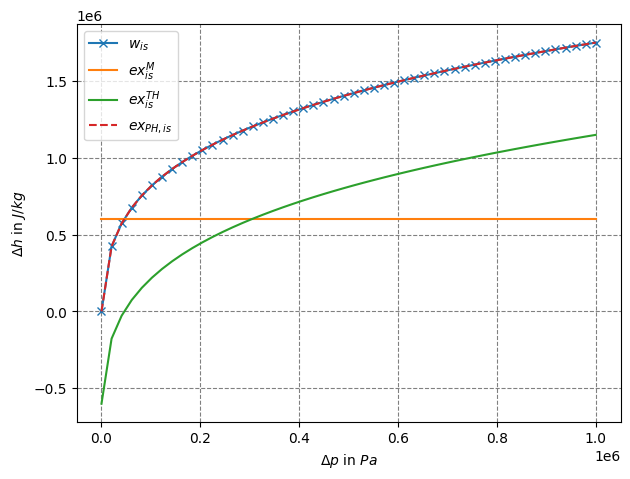

In [4]:
s_ref = PropsSI("S", "P", p_ref, "T", T_ref, "air")
h_is = PropsSI("H", "P", p_range, "S", s_ref, "air")
T_is = PropsSI("T", "P", p_range, "S", s_ref, "air")

ex_therm = []
ex_mech = []
ex = []

for p, T in zip(p_range, T_is):
    c.h.val_SI = PropsSI("H", "P", p, "T", T, "air")
    c.s.val_SI = PropsSI("S", "P", p, "T", T, "air")
    c.get_physical_exergy(p_ref, T_ref)
    ex_therm += [c.ex_therm]
    ex_mech += [c.ex_mech]
    ex += [c.ex_physical]
    

fig, ax = plt.subplots(1)

ax.set_xlabel("$\Delta p$ in $Pa$")
ax.set_ylabel("$\Delta h$ in $J/kg$")

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.tight_layout()
    
ax.plot(p_range, h_is - ref.h.val_SI, "x-", label="$w_{is}$")
ax.plot(p_range, ex_mech, label="$ex^{M}_{is}$")
ax.plot(p_range, ex_therm, label="$ex^{TH}_{is}$")
ax.plot(p_range, ex, "--", label="$ex_{PH,is}$")

ax.legend()
plt.show()

We can now inspect the change of energy in the cooling process (assuming isobaric).

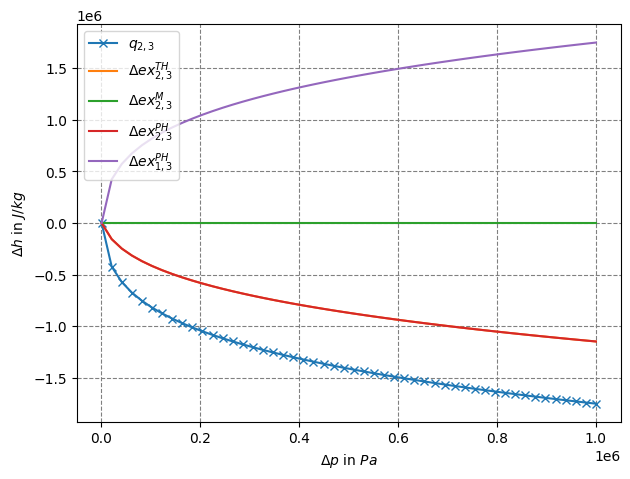

In [5]:
h_is = PropsSI("H", "P", p_range, "S", s_ref, "air")
h_3 = PropsSI("H", "P", p_range, "T", T_ref, "air")

dex_therm = []
dex_mech = []
dex = []

for p, T in zip(p_range, T_is):
    c.h.val_SI = PropsSI("H", "P", p, "T", T, "air")
    c.s.val_SI = PropsSI("S", "P", p, "T", T, "air")
    c.get_physical_exergy(p_ref, T_ref)
    ex_therm_is, ex_mech_is, ex_is = c.ex_therm, c.ex_mech, c.ex_physical
    c.h.val_SI = PropsSI("H", "P", p, "T", T_ref, "air")
    c.s.val_SI = PropsSI("S", "P", p, "T", T_ref, "air")
    c.get_physical_exergy(p_ref, T_ref)
    dex_therm += [c.ex_therm - ex_therm_is]
    dex_mech += [c.ex_mech - ex_mech_is]
    dex += [c.ex_physical - ex_is]
    

fig, ax = plt.subplots(1)

ax.set_xlabel("$\Delta p$ in $Pa$")
ax.set_ylabel("$\Delta h$ in $J/kg$")

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.tight_layout()

ax.plot(p_range, h_3 - h_is, "x-", label="$q_{2,3}$")
ax.plot(p_range, dex_therm, label="$\Delta ex^{TH}_{2,3}$")
ax.plot(p_range, dex_mech, label="$\Delta ex^{M}_{2,3}$")
ax.plot(p_range, dex, label="$\Delta ex^{PH}_{2,3}$")
ax.plot(p_range, ex, label="$\Delta ex^{PH}_{1,3}$")

ax.legend()
plt.show()

## Excercises

# 2 Simple Thermodynamic cycles

Ziele des Kapitels
- Wie kann die Methode in einfacheren Mehrkomponentensystemen angewendet werden
- Welche Vorteile bietet sie der einfachen Energieanalyse gegenüber
- Wie kann die Methode "sichtbar" gemacht werden? (Einführung in unterschiedliche Darstellungsformen)
- Wie/warum wirken sich Eigenschaften der Komponenten und des Prozesses auf den Gesamtprozess aus?

## Heat Pump

## Clausius Rankine Cycle

## Gas Turbine

## Excercises

# 3 Processes with multiple inputs and outputs

Ziele des Kapitels
- Unterschiedlich wertige Energien in Praxisbeispielen darstellen, um den Unterschied zwischen Energie und Exergy zu verdeutlichen
- ...

## Combined Heat and Power

## Electrolysis with Waste Heat Recovery 

## Excercises

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)